# Let's visualize dataset to understand! 🚙三

It may be difficult to imagine what kind of data we are dealing with in the first place. We have focused on the visualization of ground truth of smartphone tracks to help you understand the data better. As we work through the competition, we will want to know how accurately our solution reproduces the trackings, and I also hope this will be helpful in visualizing them.

## <u>Note</u>

Cells where you can change the analysis target by changing the values, I'll mark with orange sentence <span style="color: orange; ">like this</span>!!!

## Contents

* [Background](#1)
  * [Goal](#1-1)
  * [About dataset](#1-2)
* [Data overview](#2)
  * [Load data and see overview](#2-1)
  * [How to check track in detail?](#2-2)
  * [How to check large amounts of tracks?](#2-3)
  * [How to check tracks in animation?](#2-4)
  * [How to load data from .nmea file](#2-5)
* [Appendix](#3)
  * [Distribution of rollDegs of phones](#3-1)
  * [Which collection contains which phone](#3-2)

In [1]:
!pip install pynmea2

import glob
import itertools
import json
import os
import warnings
warnings.filterwarnings('ignore')

import geopandas as gpd
from geopandas import GeoDataFrame
import geoplot as gplt
from IPython.display import Video
from matplotlib import animation
import matplotlib.pyplot as plt
import numpy as np 
import pandas as pd
import plotly.express as px
import pynmea2
import requests
import seaborn
from shapely.geometry import Point, shape
import shapely.wkt

%matplotlib inline

DATA_PATH = "../input/google-smartphone-decimeter-challenge/"

<a id="1"></a>
# Background

<a id="1-1"></a>
## Goal

The goal of this competition is to compute location (latDeg and lngDeg) down to decimeter or even centimeter resolution, if possible for each test phone and time.

Our submission file is like this.

In [2]:
sub = pd.read_csv(DATA_PATH + "sample_submission.csv")
sub.head()

phone  millisSinceGpsEpoch     latDeg     lngDeg
0  2020-05-15-US-MTV-1_Pixel4        1273608785432  37.904611 -86.481078
1  2020-05-15-US-MTV-1_Pixel4        1273608786432  37.904611 -86.481078
2  2020-05-15-US-MTV-1_Pixel4        1273608787432  37.904611 -86.481078
3  2020-05-15-US-MTV-1_Pixel4        1273608788432  37.904611 -86.481078
4  2020-05-15-US-MTV-1_Pixel4        1273608789432  37.904611 -86.481078

latDeg and lngDeg are our target.

We can use GPS tracking data and variety of sensor data to improve our solution. 

<a id="1-2"></a>
## About dataset 

Google releases 60+ datasets collected from phones in the Android GPS team, together with corrections from SwiftNavigation Inc. and Verizon Inc. These datasets were collected on highways in the US San Francisco Bay Area in the summer of 2020. We can see the video for dataset.

In [3]:
!cp "../input/android-smartphones-high-accuracy-datasets/ION GNSS 2020 Presentation (Michael Fu).mp4" ION_GNSS_2020_Presentation.mp4

In [4]:
Video("ION_GNSS_2020_Presentation.mp4", width=640, height=640)

We are given data from actual runs with android devices installed in cars, see following. 

![](https://raw.githubusercontent.com/tasotasoso/kaggle_media/main/Android_smartphones_high_accuracy_GNSS_datasets/fig3_fig4.JPG)

<font size="1">The figures come from <I>Fu, Guoyu (Michael), Khider, Mohammed, van Diggelen, Frank, "Android Raw GNSS Measurement Datasets for Precise Positioning," Proceedings of the 33rd International Technical Meeting of the Satellite Division of The Institute of Navigation (ION GNSS+ 2020), September 2020, pp. 1925-1937.
[https://doi.org/10.33012/2020.17628](https://www.ion.org/publications/abstract.cfm?articleID=17628)</I></font>

We can see more detail of data collection process at [Android smartphones high accuracy GNSS datasets](https://www.kaggle.com/google/android-smartphones-high-accuracy-datasets).

 Devices can be one thing or multiple things. Data collection trials are separated as collectionName like this.

In [5]:
!ls ../input/google-smartphone-decimeter-challenge/train

2020-05-14-US-MTV-1  2020-07-08-US-MTV-1  2021-01-05-US-SVL-2
2020-05-14-US-MTV-2  2020-07-17-US-MTV-1  2021-03-10-US-SVL-1
2020-05-21-US-MTV-1  2020-07-17-US-MTV-2  2021-04-15-US-MTV-1
2020-05-21-US-MTV-2  2020-08-03-US-MTV-1  2021-04-22-US-SJC-1
2020-05-29-US-MTV-1  2020-08-06-US-MTV-2  2021-04-26-US-SVL-1
2020-05-29-US-MTV-2  2020-09-04-US-SF-1   2021-04-28-US-MTV-1
2020-06-04-US-MTV-1  2020-09-04-US-SF-2   2021-04-28-US-SJC-1
2020-06-05-US-MTV-1  2021-01-04-US-RWC-1  2021-04-29-US-MTV-1
2020-06-05-US-MTV-2  2021-01-04-US-RWC-2  2021-04-29-US-SJC-2
2020-06-11-US-MTV-1  2021-01-05-US-SVL-1


Under each collectionName, the data of the device is stored.

In [6]:
!ls ../input/google-smartphone-decimeter-challenge/train/2020-05-14-US-MTV-1/

Pixel4	Pixel4XLModded


In addition, the data collected from each device, groundtruth, and supplemental data are stored under it.

In [7]:
!ls ../input/google-smartphone-decimeter-challenge/train/2020-05-14-US-MTV-1/Pixel4

Pixel4_GnssLog.txt  Pixel4_derived.csv	ground_truth.csv  supplemental


In [8]:
!ls ../input/google-smartphone-decimeter-challenge/train/2020-05-14-US-MTV-1/Pixel4/supplemental

Pixel4_GnssLog.20o  SPAN_Pixel4_10Hz.nmea


The supplemental data contains the raw data that was measured, and I'll show way to read nmea.

<a id="2"></a>
# Data overview

<a id="2-1"></a>
## Load data and see overview

You can use [train/test]/[drive_id]/[phone_name]/[phone_name]_derived.csv as organized data. And also we can use ground_truth.csv as reference. Let's open one of the files and see what it contains.

In [9]:
!ls ../input/google-smartphone-decimeter-challenge/train/2020-05-14-US-MTV-1/

Pixel4	Pixel4XLModded


In [10]:
df_sample_trail = pd.read_csv(DATA_PATH + "train/2020-05-14-US-MTV-1/Pixel4/Pixel4_derived.csv")
df_sample_trail_gt = pd.read_csv(DATA_PATH + "train/2020-05-14-US-MTV-1/Pixel4/ground_truth.csv")

In [11]:
df_sample_trail.head()

collectionName phoneName  millisSinceGpsEpoch  constellationType  \
0  2020-05-14-US-MTV-1    Pixel4        1273529464442                  3   
1  2020-05-14-US-MTV-1    Pixel4        1273529464442                  6   
2  2020-05-14-US-MTV-1    Pixel4        1273529464442                  1   
3  2020-05-14-US-MTV-1    Pixel4        1273529464442                  6   
4  2020-05-14-US-MTV-1    Pixel4        1273529464442                  6   

   svid signalType  receivedSvTimeInGpsNanos      xSatPosM      ySatPosM  \
0    24     GLO_G1       1273529463363061857 -2.539901e+07 -6.925122e+05   
1    13     GAL_E1       1273529463363970742 -5.199894e+06 -1.741927e+07   
2     5     GPS_L1       1273529463365539137 -2.179863e+06 -2.615488e+07   
3    15     GAL_E1       1273529463352380595  1.635469e+07 -1.047833e+07   
4    21     GAL_E1       1273529463364075083 -1.484042e+07 -2.110960e+07   

       zSatPosM  xSatVelMps  ySatVelMps  zSatVelMps  satClkBiasM  \
0 -2.280430e+06    -325.826     156.040    3559.757     -468.084   
1  2.336128e+07    2239.305     700.815    1022.014   120171.076   
2 -3.437694e+06     325.541    -419.725    3129.012    -3793.067   
3  2.234460e+07    2172.409     561.971   -1326.001   259937.286   
4  1.449632e+07    -426.094   -1395.675   -2467.793  -179555.991   

   satClkDriftMps        rawPrM  rawPrUncM     isrbM  ionoDelayM  tropoDelayM  
0           0.001  2.379498e+07     11.992  1134.758      10.866       16.647  
1           0.000  2.352251e+07      1.799  -222.675       3.946        2.717  
2          -0.001  2.305231e+07      4.197     0.000       7.554        5.704  
3          -0.000  2.699715e+07      8.094  -222.675       7.968        9.151  
4          -0.001  2.349123e+07      2.698  -222.675       3.834        2.544

In [12]:
df_sample_trail.columns

Index(['collectionName', 'phoneName', 'millisSinceGpsEpoch',
       'constellationType', 'svid', 'signalType', 'receivedSvTimeInGpsNanos',
       'xSatPosM', 'ySatPosM', 'zSatPosM', 'xSatVelMps', 'ySatVelMps',
       'zSatVelMps', 'satClkBiasM', 'satClkDriftMps', 'rawPrM', 'rawPrUncM',
       'isrbM', 'ionoDelayM', 'tropoDelayM'],
      dtype='object')

In [13]:
df_sample_trail_gt.head()

collectionName phoneName  millisSinceGpsEpoch     latDeg      lngDeg  \
0  2020-05-14-US-MTV-1    Pixel4        1273529463442  37.423576 -122.094132   
1  2020-05-14-US-MTV-1    Pixel4        1273529464442  37.423576 -122.094132   
2  2020-05-14-US-MTV-1    Pixel4        1273529465442  37.423576 -122.094132   
3  2020-05-14-US-MTV-1    Pixel4        1273529466442  37.423576 -122.094132   
4  2020-05-14-US-MTV-1    Pixel4        1273529467442  37.423576 -122.094132   

   heightAboveWgs84EllipsoidM  timeSinceFirstFixSeconds  hDop  vDop  speedMps  \
0                       33.21                    551.44   1.1   0.0       0.0   
1                       33.21                    552.44   1.1   0.0       0.0   
2                       33.21                    553.44   1.1   0.0       0.0   
3                       33.20                    554.44   1.1   0.0       0.0   
4                       33.20                    555.44   1.1   0.0       0.0   

   courseDegree  
0          12.7  
1          12.7  
2          12.7  
3          12.7  
4          12.7

In [14]:
df_sample_trail_gt.columns

Index(['collectionName', 'phoneName', 'millisSinceGpsEpoch', 'latDeg',
       'lngDeg', 'heightAboveWgs84EllipsoidM', 'timeSinceFirstFixSeconds',
       'hDop', 'vDop', 'speedMps', 'courseDegree'],
      dtype='object')

<a id="2-2"></a>
## How to check track in detail?

We can use plotly to see our model or ground truth like this. To see trafic, you should adjust map centor and scale.



In [15]:
def visualize_trafic(df, center, zoom=9):
    fig = px.scatter_mapbox(df,
                            
                            # Here, plotly gets, (x,y) coordinates
                            lat="latDeg",
                            lon="lngDeg",
                            
                            #Here, plotly detects color of series
                            color="phoneName",
                            labels="phoneName",
                            
                            zoom=zoom,
                            center=center,
                            height=600,
                            width=800)
    fig.update_layout(mapbox_style='stamen-terrain')
    fig.update_layout(margin={"r": 0, "t": 0, "l": 0, "b": 0})
    fig.update_layout(title_text="GPS trafic")
    fig.show()

### <span style="color: orange; ">↓↓↓ If you want to check other track, you should load the data in below cell.</span>

In [16]:
# I will reload dataframe so that it is easy to look at other data.
df_sample_trail_gt = pd.read_csv(DATA_PATH + "train/2020-05-14-US-MTV-1/Pixel4/ground_truth.csv")

center = {"lat":37.423576, "lon":-122.094132}
visualize_trafic(df_sample_trail_gt, center)

Data which have same collectionName seems have same ground truth.
### <span style="color: orange; ">↓↓↓ If you want to check other track, you should load the data in below cell.</span>

In [17]:
# I will reload dataframe so that it is easy to look at other data.
df_sample_trail_gt = pd.read_csv(DATA_PATH + "train/2020-05-14-US-MTV-1/Pixel4/ground_truth.csv")
df_sample_trail_gt2 = pd.read_csv(DATA_PATH + "train/2020-05-14-US-MTV-1/Pixel4XLModded/ground_truth.csv")

# Since plotly looks at the phoneName of the dataframe,
# you can visualize multiple series of data by simply concatting dataframes.
df_sample_trail_gt3 = pd.concat([df_sample_trail_gt, df_sample_trail_gt2])

center = {"lat":37.423576, "lon":-122.094132}
visualize_trafic(df_sample_trail_gt3, center)

<a id="2-3"></a>
## How to check large amounts of tracks?

Earlier we saw how to use plotly to map data on OpenStreetMap. This time, since there is a certain amount of tracking data in the train data alone, I will also show you how to use geopandas to get a quick overview as a regular diagram.

From here on, the cells will be hidden for a while, because the procedure is necessary for visualization and we will get tired of following everything. If you have interest, please open and check them accordingly.

First, I'll download shape file lof bayarea.

In [18]:
#Download geojson file of US San Francisco Bay Area.
r = requests.get("https://data.sfgov.org/api/views/wamw-vt4s/rows.json?accessType=DOWNLOAD")
r.raise_for_status()

#get geojson from response
data = r.json()

#get polygons that represents San Francisco Bay Area.
shapes = []
for d in data["data"]:
    shapes.append(shapely.wkt.loads(d[8]))
    
#Convert list of porygons to geopandas dataframe.
gdf_bayarea = pd.DataFrame()

#I'll use only 6 and 7th object.
for shp in shapes[5:7]:
    tmp = pd.DataFrame(shp, columns=["geometry"])
    gdf_bayarea = pd.concat([gdf_bayarea, tmp])
gdf_bayarea = GeoDataFrame(gdf_bayarea)

For each collectionNames, read the ground truth files in format that is convenient for visualization. At this time, we have already converted it to geopandas dataframe.

In [19]:
collectionNames = [item.split("/")[-1] for item in glob.glob("../input/google-smartphone-decimeter-challenge/train/*")]

gdfs = []
for collectionName in collectionNames:
    gdfs_each_collectionName = []
    csv_paths = glob.glob(f"../input/google-smartphone-decimeter-challenge/train/{collectionName}/*/ground_truth.csv")
    for csv_path in csv_paths:
        df_gt = pd.read_csv(csv_path)
        df_gt["geometry"] = [Point(lngDeg, latDeg) for lngDeg, latDeg in zip(df_gt["lngDeg"], df_gt["latDeg"])]
        gdfs_each_collectionName.append(GeoDataFrame(df_gt))
    gdfs.append(gdfs_each_collectionName)

In [20]:
colors = ['blue', 'green', 'purple', 'orange']

Now, let's visualize tracks. Some of them were too small to be seen when projected on the map, so we put them side by side with the ones that are just routes.

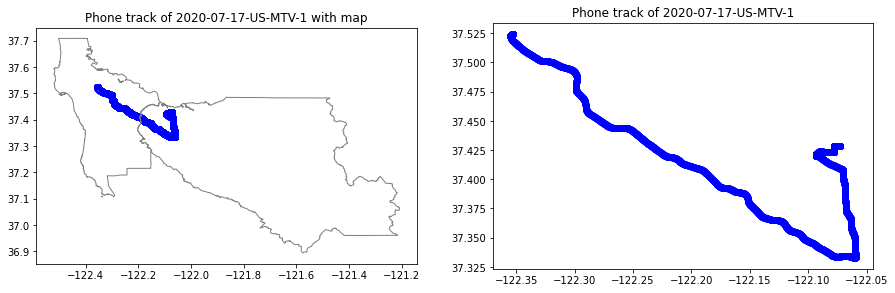

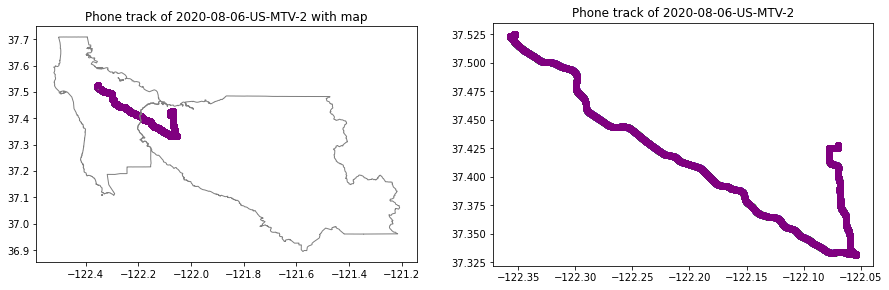

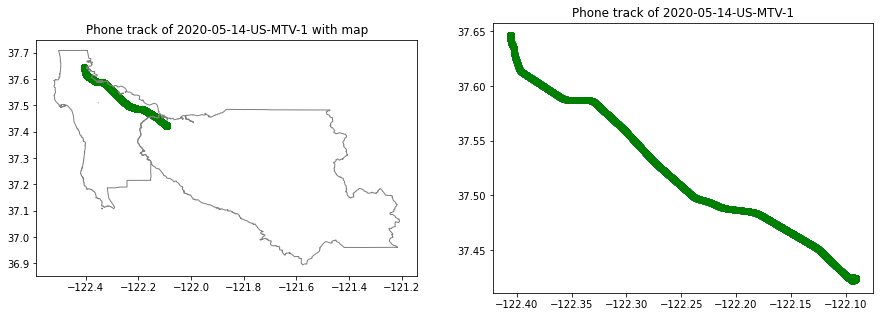

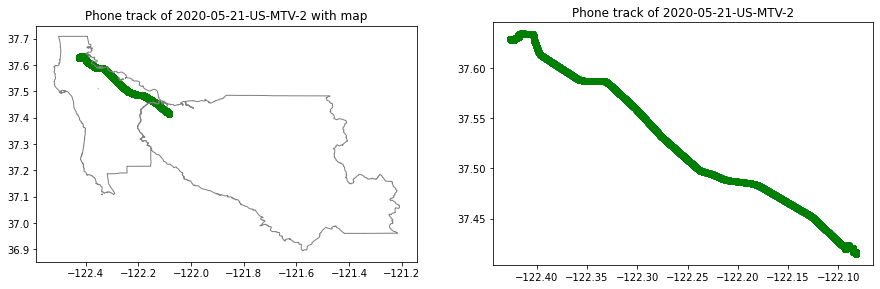

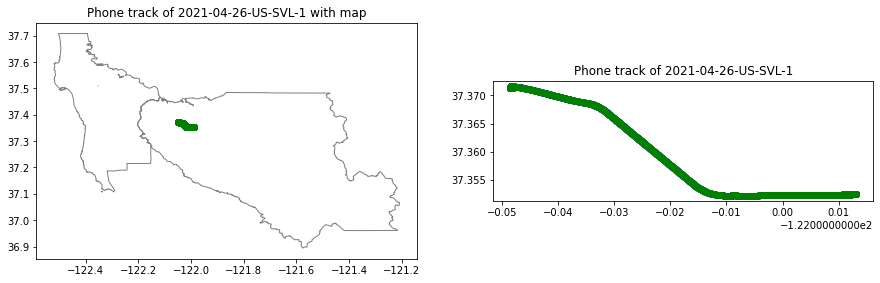

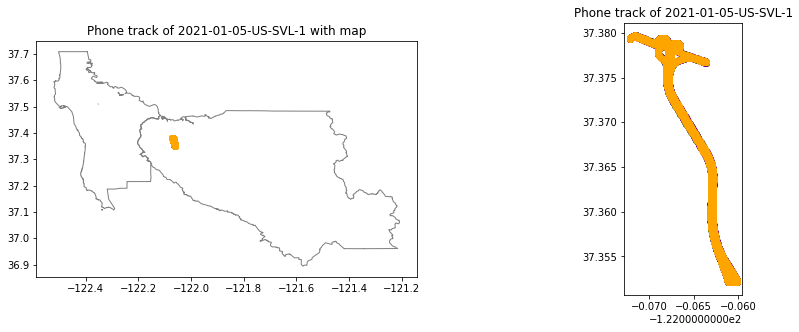

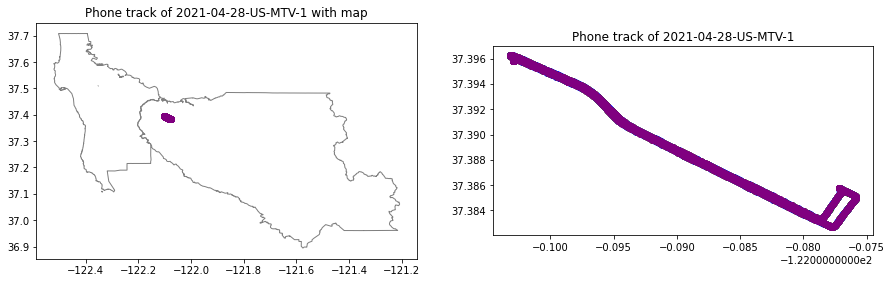

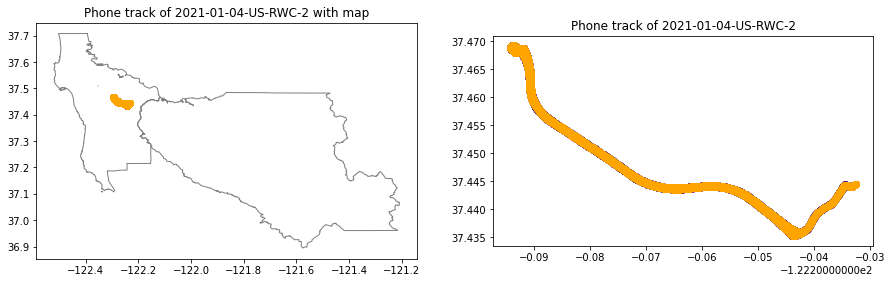

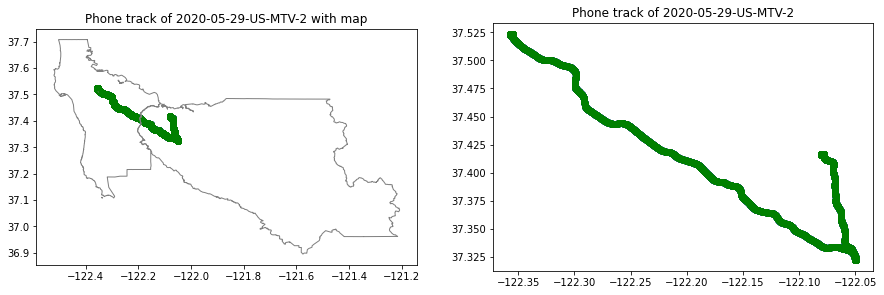

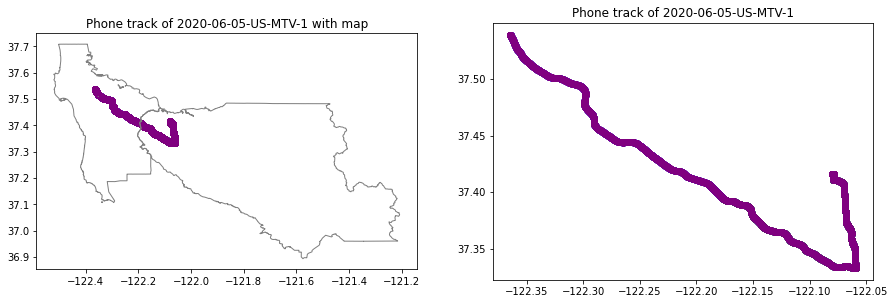

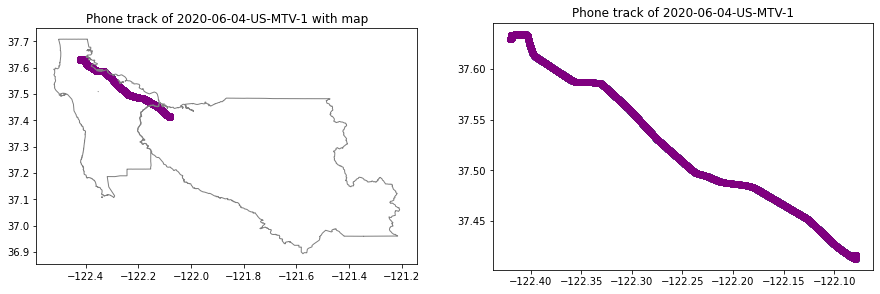

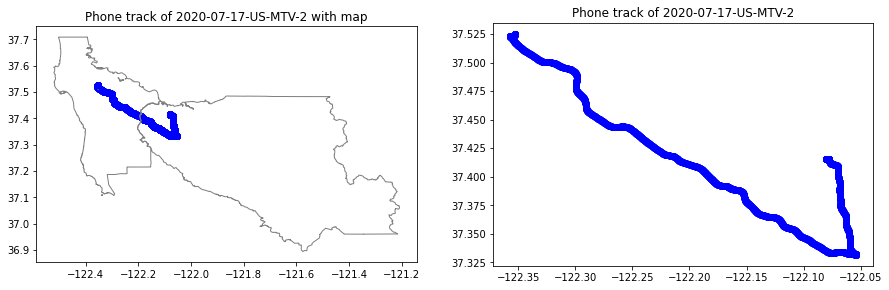

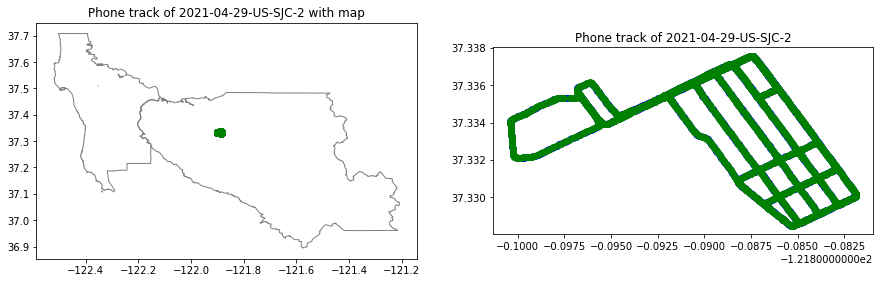

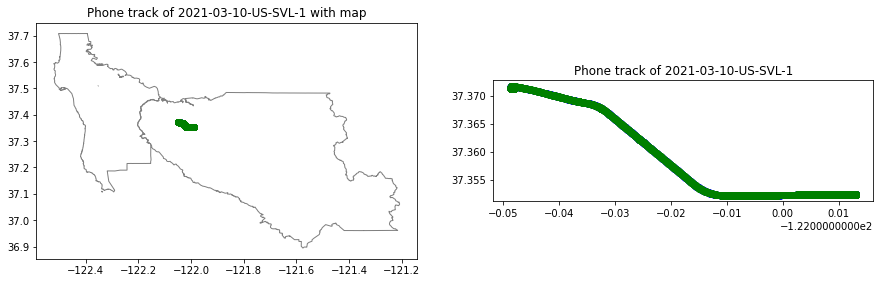

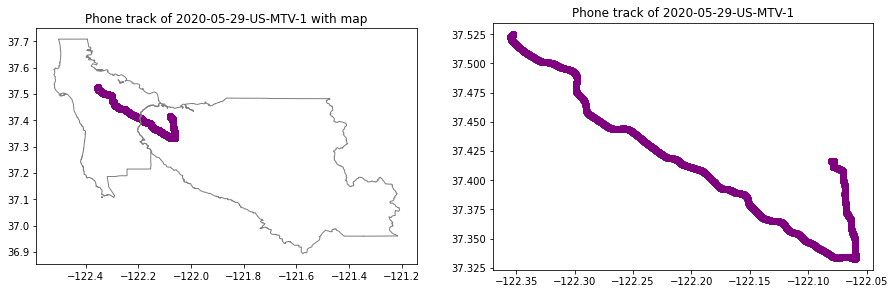

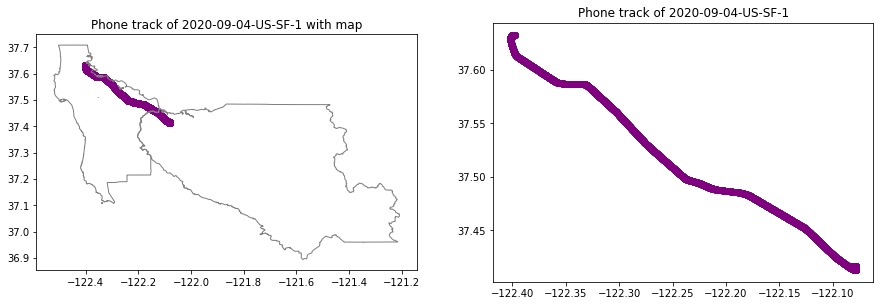

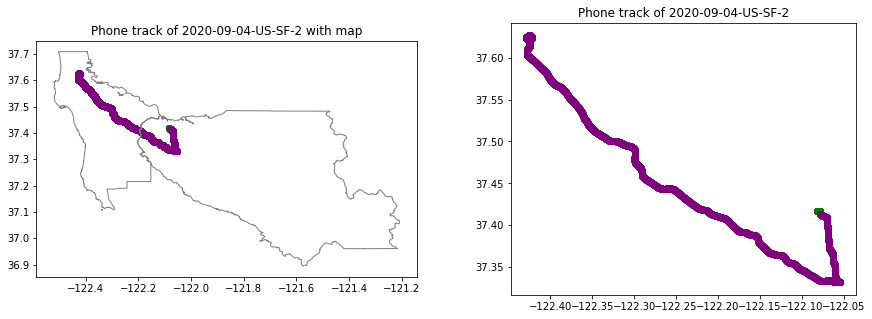

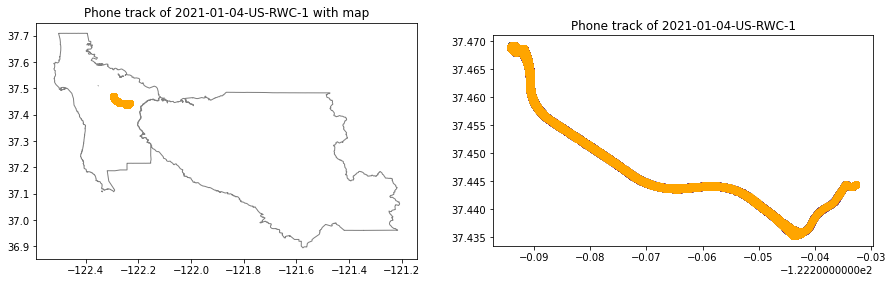

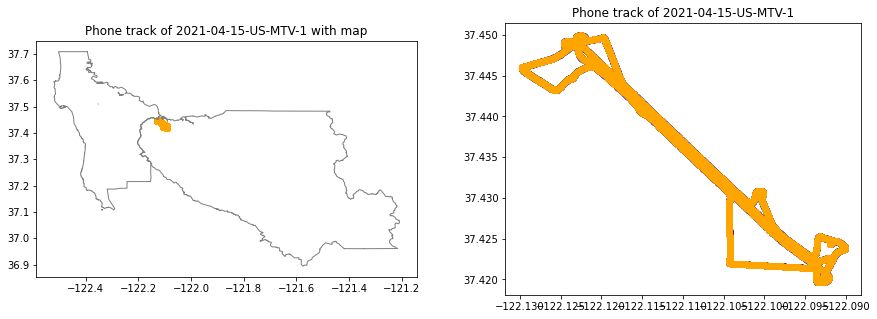

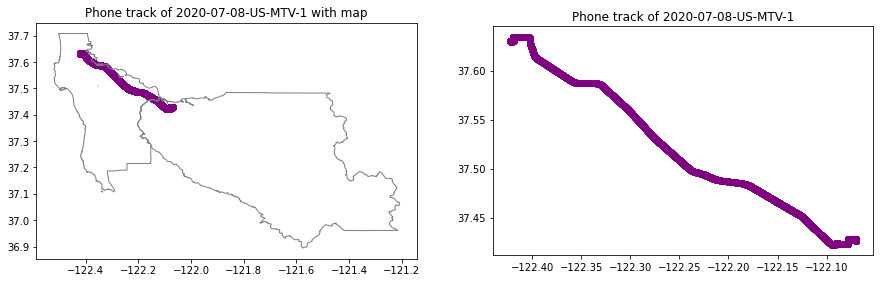

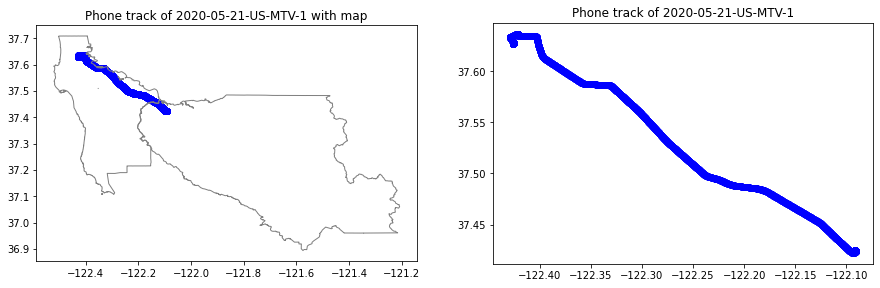

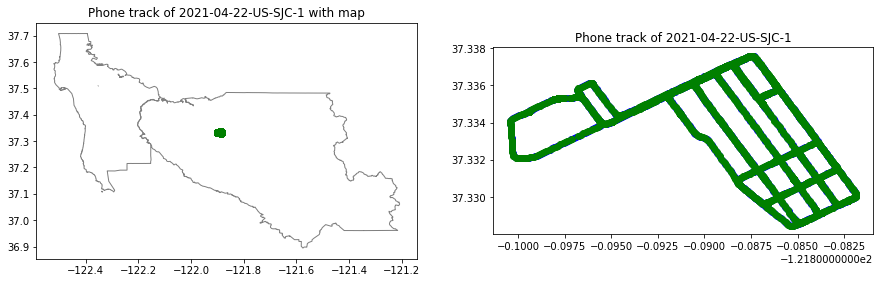

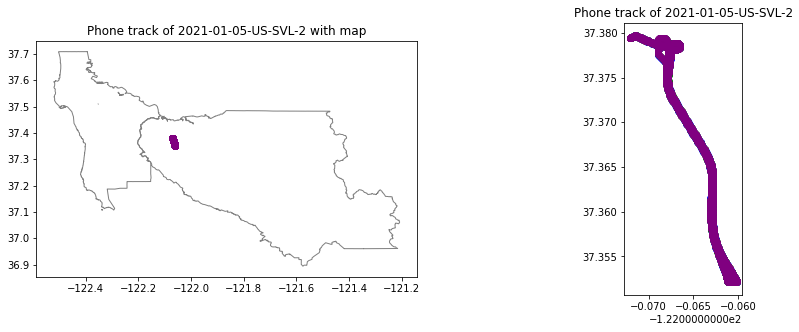

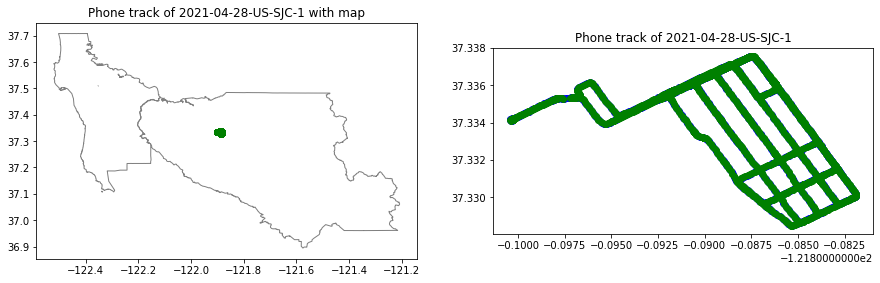

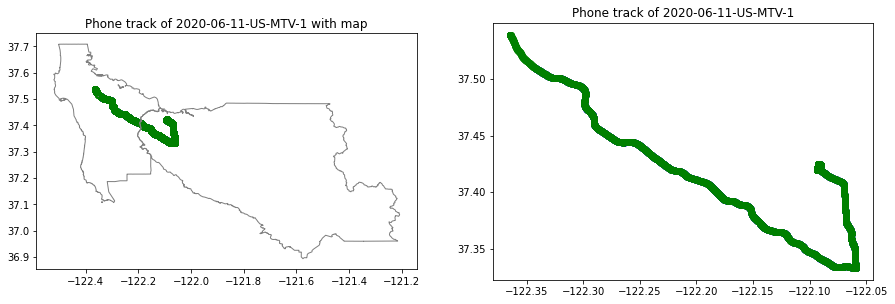

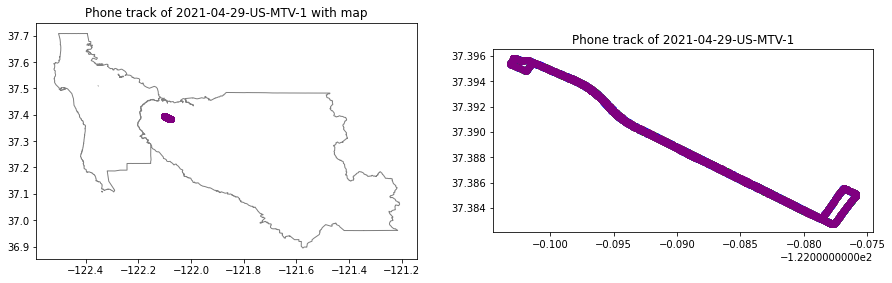

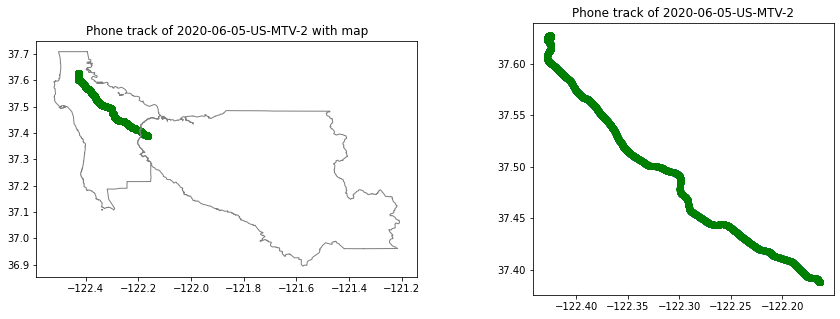

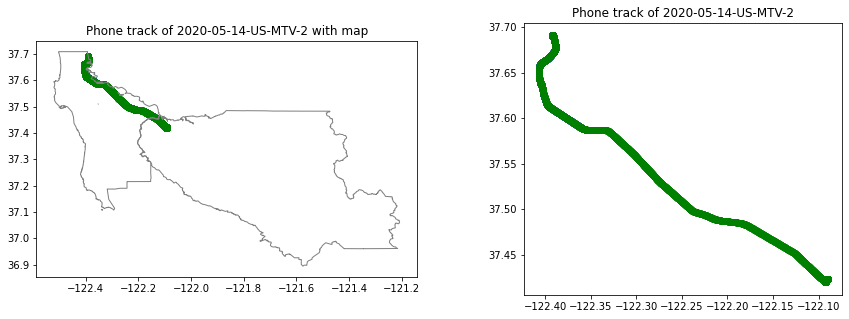

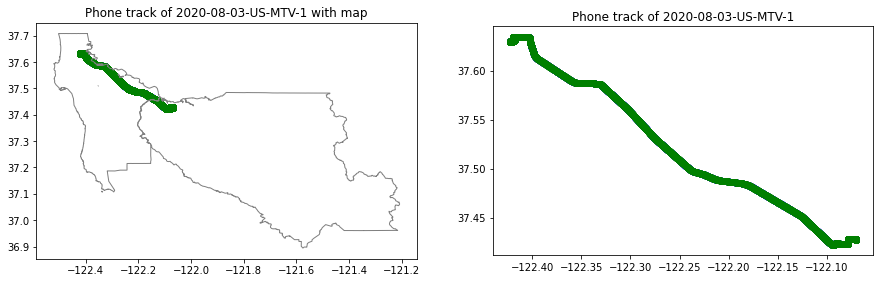

In [21]:
for collectionName, gdfs_each_collectionName in zip(collectionNames, gdfs):
    fig, axs = plt.subplots(1, 2, figsize=(15, 5))
    gdf_bayarea.plot(figsize=(10,10), color='none', edgecolor='gray', zorder=3, ax=axs[0])
    for i, gdf in enumerate(gdfs_each_collectionName):
        g1 = gdf.plot(color=colors[i], ax=axs[0])
        g1.set_title(f"Phone track of {collectionName} with map")
        g2 = gdf.plot(color=colors[i], ax=axs[1])
        g2.set_title(f"Phone track of {collectionName}")

There are several tracks that have the same form of data with different collectionName. It is easy to understand the positional relationship by overlapping them. There are two roads extending from the northwest to the southeast, and they seem to run along those roads all the time, or occasionally go off those roads. The tracks wandering around the grid-like paths seem to be collected farther southeast than those paths.

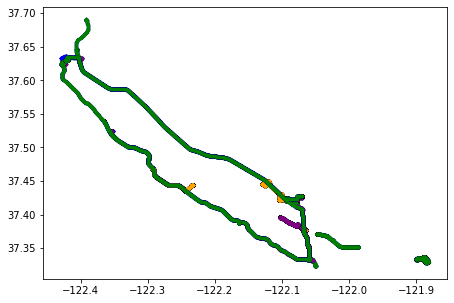

In [22]:
fig, ax = plt.subplots(figsize=(15, 5))

for collectionName, gdfs_each_collectionName in zip(collectionNames, gdfs):   
    for i, gdf in enumerate(gdfs_each_collectionName):
        gdf.plot(color=colors[i], ax=ax, markersize=5, alpha=0.5)

In geopandas, it's easy to see where they are in relation to each other, but it's hard to see the details and geographic information, so let's look at them with plotly as well.

In [23]:
all_tracks = pd.DataFrame()

for collectionName, gdfs_each_collectionName in zip(collectionNames, gdfs):   
    for i, gdf in enumerate(gdfs_each_collectionName):
        all_tracks = pd.concat([all_tracks, gdf])
        # Tracks they have same collectionName is also same
        break
        
fig = px.scatter_mapbox(all_tracks,
                            
                        # Here, plotly gets, (x,y) coordinates
                        lat="latDeg",
                        lon="lngDeg",
                            
                        #Here, plotly detects color of series
                        color="collectionName",
                        labels="collectionName",
                            
                        zoom=9,
                        center={"lat":37.423576, "lon":-122.094132},
                        height=600,
                        width=800)
fig.update_layout(mapbox_style='stamen-terrain')
fig.update_layout(margin={"r": 0, "t": 0, "l": 0, "b": 0})
fig.update_layout(title_text="GPS trafic")
fig.show()

<a id="2-4"></a>
##  How to check tracks in animation?

I am sure that you all would like to see animations of what the data was driving at. I have also prepared code to check the x, y coordinate movement in gif, so try it out. 

The process takes some minutes (about 2 or 3 minutes for my implement).

Note: The x, y coordinates have been thinned out (to 1/10) because the processing uses much memory. You can adjust them if necessary.

In [24]:
def create_gif_track(df, git_path):
    """ Create git animation of phone track.
    """

    fig, ax = plt.subplots()

    imgs = []
    df["geometry"] = [Point(lngDeg, latDeg) for lngDeg, latDeg in zip(df["lngDeg"], df["latDeg"])]
    gdf = GeoDataFrame(df)
    gdf.plot(color="lightskyblue", ax=ax)
    
    # Here, (x,y) coordinates are thinned out!!!
    for i in range(0, len(gdf), 10):
        # plot data
        p = ax.plot(gdf.iloc[i]["lngDeg"], gdf.iloc[i]["latDeg"], 
                    color = 'dodgerblue', marker = 'o', markersize = 8)
        imgs.append(p)

    # Create animation & save it
    ani = animation.ArtistAnimation(fig, imgs, interval=200)
    ani.save(git_path, writer='imagemagick', dpi = 300)
    

def create_gif_track_on_map(df, gdf_map, git_path):
    """ Create git animation of phone track on bayarea map.
    """

    fig, ax = plt.subplots()
    df["geometry"] = [Point(lngDeg, latDeg) for lngDeg, latDeg in zip(df["lngDeg"], df["latDeg"])]
    gdf = GeoDataFrame(df)
    gdf.plot(color="lightskyblue", ax=ax)
    imgs = []  
    gdf_map.plot(color='none', edgecolor='gray', zorder=3, ax=ax)
    
    # Here, (x,y) coordinates are thinned out!!!
    for i in range(0, len(gdf), 10):
        # plot data on map
        p = ax.plot(gdf.iloc[i]["lngDeg"], gdf.iloc[i]["latDeg"], 
                    color = 'dodgerblue', marker = 'o', markersize = 8)
        imgs.append(p)

    # Create animation & save it
    ani = animation.ArtistAnimation(fig, imgs, interval=200)
    ani.save(git_path, writer='imagemagick', dpi = 300)

### <span style="color: orange; ">↓↓↓ You can change the first argment for dataframe of visualize target and the second argment for gif file to save.</span>

CPU times: user 24.3 s, sys: 1.56 s, total: 25.9 s
Wall time: 3min 31s


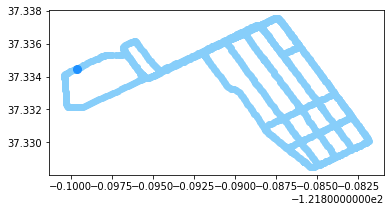

In [25]:
%%time

df_2021_04_29_US_SJC_2_Pixel4_gt = pd.read_csv(DATA_PATH + "train/2021-04-29-US-SJC-2/Pixel4/ground_truth.csv")

create_gif_track(df_2021_04_29_US_SJC_2_Pixel4_gt, "./2021_04_29_US_SJC_2_Pixel4_gt.gif")

### <span style="color: orange; ">↓↓↓ You can change the first argment for dataframe of visualize target and the third argment for gif file to save.</span>

CPU times: user 18 s, sys: 1.28 s, total: 19.3 s
Wall time: 2min


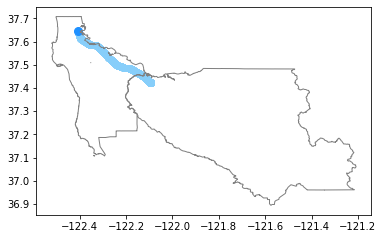

In [26]:
%%time

df_2020_05_14_US_MTV_1_Pixel4_gt = pd.read_csv(DATA_PATH + "train/2020-05-14-US-MTV-1/Pixel4/ground_truth.csv")

create_gif_track_on_map(df_2020_05_14_US_MTV_1_Pixel4_gt, gdf_bayarea, "./2020_05_14_US_MTV_1_Pixel4_gt.gif")

### Gif animation of ../input/google-smartphone-decimeter-challenge/train/2021_04_29_US_SJC_2/Pixel4/ground_truth.csv

![2021_04_29_US_SJC_2_Pixel4_gt.gif](./2021_04_29_US_SJC_2_Pixel4_gt.gif)

<div class="alert alert-block alert-info">Info: To see another gif animation you create, you can change the path of above line of this line in this markdown cell.</div>

### Gif animation of ../input/google-smartphone-decimeter-challenge/train/2020-05-14-US-MTV-1/Pixel4/ground_truth.csv

![2020_05_14_US_MTV_1_Pixel4_gt.gif](./2020_05_14_US_MTV_1_Pixel4_gt.gif)

<div class="alert alert-block alert-info">Info: To see another gif animation you create, you can change the path of above line of this line in this markdown cell.</div>

<a id="2-5"></a>
## How to load data from .nmea file

We can also use supplemental data. Now we'll see how to load .nmea file.

NMEA (National Marine Electronics Association) format is GPS file format. To extract data from .nmea file, we can use [pynmea2](https://github.com/Knio/pynmea2) library. In the NMEA file, each location is described jointly by a pair of GGA and RMC sentences, as depicted in following Figures 5 and 6.

![GGA & RMC format](https://raw.githubusercontent.com/tasotasoso/kaggle_media/main/Android_smartphones_high_accuracy_GNSS_datasets/fig5_fig6.JPG)

<font size="1">The figures come from <I>Fu, Guoyu (Michael), Khider, Mohammed, van Diggelen, Frank, "Android Raw GNSS Measurement Datasets for Precise Positioning," Proceedings of the 33rd International Technical Meeting of the Satellite Division of The Institute of Navigation (ION GNSS+ 2020), September 2020, pp. 1925-1937.
[https://doi.org/10.33012/2020.17628](https://www.ion.org/publications/abstract.cfm?articleID=17628)</I></font>

In [27]:
with open(DATA_PATH + "train/2020-05-14-US-MTV-1/Pixel4/supplemental/SPAN_Pixel4_10Hz.nmea", encoding='utf-8') as nmea_f:
    for line in nmea_f.readlines():
        try:
            msg = pynmea2.parse(line)
            break
        except pynmea2.ParseError as e:
            pass
        
print(repr(msg))
print("---------------------------------")
print("timestamp:", msg.timestamp)
print("lat:", msg.lat)
print("lat_dir:", msg.lat_dir)
print("lon:", msg.lon)
print("lon_dir:", msg.lon_dir)
print("gps_qual:", msg.gps_qual)
print("num_sats:", msg.num_sats)
print("horizontal_dil:", msg.horizontal_dil)
print("altitude:", msg.altitude)
print("altitude_units:", msg.altitude_units)
print("geo_sep:", msg.geo_sep)
print("geo_sep_units:", msg.geo_sep_units)
print("age_gps_data:", msg.age_gps_data)
print("ref_station_id:", msg.ref_station_id)
print("---------------------------------")

<GGA(timestamp=datetime.time(22, 1, 34), lat='3725.4168121', lat_dir='N', lon='12205.6498009', lon_dir='W', gps_qual=1, num_sats='14', horizontal_dil='1.0', altitude=2.7, altitude_units='M', geo_sep='-32.64', geo_sep_units='M', age_gps_data='', ref_station_id='')>
---------------------------------
timestamp: 22:01:34
lat: 3725.4168121
lat_dir: N
lon: 12205.6498009
lon_dir: W
gps_qual: 1
num_sats: 14
horizontal_dil: 1.0
altitude: 2.7
altitude_units: M
geo_sep: -32.64
geo_sep_units: M
age_gps_data: 
ref_station_id: 
---------------------------------


In [28]:
def load_nmea_file(nmea_path):
    """Convert GGA sentences of nmea files to pandas dataframe.
    """
    
    gga_lines = []
    with open(nmea_path, encoding='utf-8') as nmea_f:
        for line in nmea_f.readlines():
            try:
                msg = pynmea2.parse(line)
                gga_lines.append(msg)
            except pynmea2.ParseError as e:
                pass
            
      
    return pd.DataFrame(gga_lines)

In [29]:
nmea_sample = load_nmea_file(DATA_PATH + "train/2020-05-14-US-MTV-1/Pixel4/supplemental/SPAN_Pixel4_10Hz.nmea")

<a id="3"></a>
# Appendix

Additional analysis of personal interest is posted here for reference.

<a id="3-1"></a>
## Distribution of rollDegs of phones

From the fact that the phones are standing up in the car like image above, and from the definition of rollDeg, we should be able to tell which direction the phone traveled by checking rollDeg.

From [Data](https://www.kaggle.com/c/google-smartphone-decimeter-challenge/data), 

> rollDeg - Roll, angle of rotation about the y axis. This value represents the angle between a plane perpendicular to the device's screen and a plane perpendicular to the ground.

I am interested in this point because I guess direction phone rotate will affect where go next. Some devices are able to take rollDeg and some don't. I am particularly interested in whether the data is available for all orientations. Unfortunately, rollDeg is only available for logs collected after March 2021.

In [30]:
# https://www.kaggle.com/carlmcbrideellis/google-smartphone-decimeter-eda

def gnss_log_to_dataframes(path):
    print('Loading ' + path, flush=True)
    gnss_section_names = {'Raw','UncalAccel', 'UncalGyro', 'UncalMag', 'Fix', 'Status', 'OrientationDeg'}
    with open(path) as f_open:
        datalines = f_open.readlines()

    datas = {k: [] for k in gnss_section_names}
    gnss_map = {k: [] for k in gnss_section_names}
    for dataline in datalines:
        is_header = dataline.startswith('#')
        dataline = dataline.strip('#').strip().split(',')
        # skip over notes, version numbers, etc
        if is_header and dataline[0] in gnss_section_names:
            gnss_map[dataline[0]] = dataline[1:]
        elif not is_header:
            datas[dataline[0]].append(dataline[1:])

    results = dict()
    for k, v in datas.items():
        results[k] = pd.DataFrame(v, columns=gnss_map[k])
    # pandas doesn't properly infer types from these lists by default
    for k, df in results.items():
        for col in df.columns:
            if col == 'CodeType':
                continue
            results[k][col] = pd.to_numeric(results[k][col])

    return results

In [31]:
gnsslog_paths = glob.glob(f"../input/google-smartphone-decimeter-challenge/train/*")

dfs = []
for collectionName in collectionNames:
    dfs_each_collectionName = []
    gnsslog_paths = glob.glob(f"../input/google-smartphone-decimeter-challenge/train/{collectionName}/*/*_GnssLog.txt")
    for gnsslog_path in gnsslog_paths:
        try:
            orientation_degs = gnss_log_to_dataframes(gnsslog_path)["OrientationDeg"]
        except:
            print(f"pass {gnsslog_path}")
            dfs_each_collectionName.append(pd.DataFrame())
            continue
        dfs_each_collectionName.append(orientation_degs)
    dfs.append(dfs_each_collectionName)

Loading ../input/google-smartphone-decimeter-challenge/train/2020-07-17-US-MTV-1/Mi8/Mi8_GnssLog.txt
Loading ../input/google-smartphone-decimeter-challenge/train/2020-08-06-US-MTV-2/Pixel4XL/Pixel4XL_GnssLog.txt
Loading ../input/google-smartphone-decimeter-challenge/train/2020-08-06-US-MTV-2/Mi8/Mi8_GnssLog.txt
Loading ../input/google-smartphone-decimeter-challenge/train/2020-08-06-US-MTV-2/Pixel4/Pixel4_GnssLog.txt
Loading ../input/google-smartphone-decimeter-challenge/train/2020-05-14-US-MTV-1/Pixel4XLModded/Pixel4XLModded_GnssLog.txt
Loading ../input/google-smartphone-decimeter-challenge/train/2020-05-14-US-MTV-1/Pixel4/Pixel4_GnssLog.txt
Loading ../input/google-smartphone-decimeter-challenge/train/2020-05-21-US-MTV-2/Pixel4XL/Pixel4XL_GnssLog.txt
Loading ../input/google-smartphone-decimeter-challenge/train/2020-05-21-US-MTV-2/Pixel4/Pixel4_GnssLog.txt
Loading ../input/google-smartphone-decimeter-challenge/train/2021-04-26-US-SVL-1/Pixel5/Pixel5_GnssLog.txt
Loading ../input/google-s

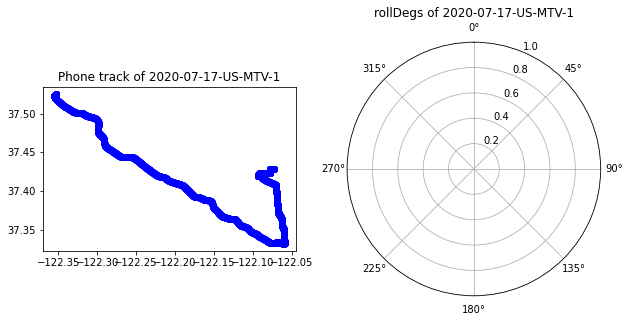

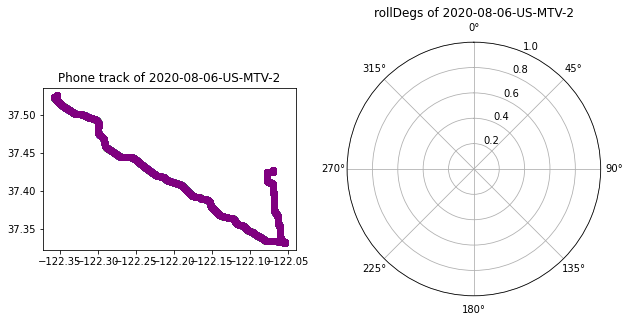

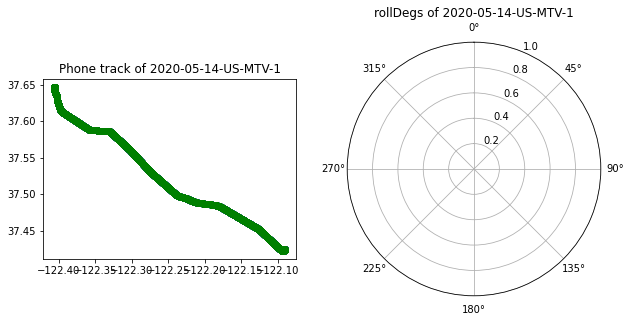

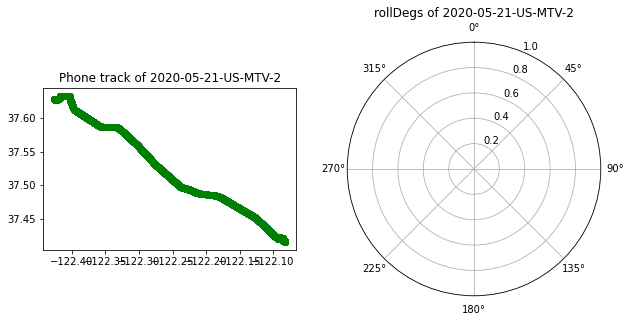

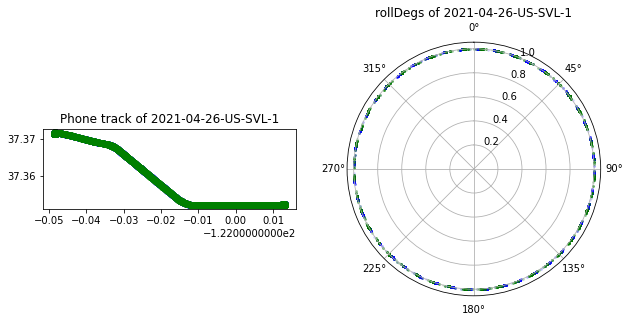

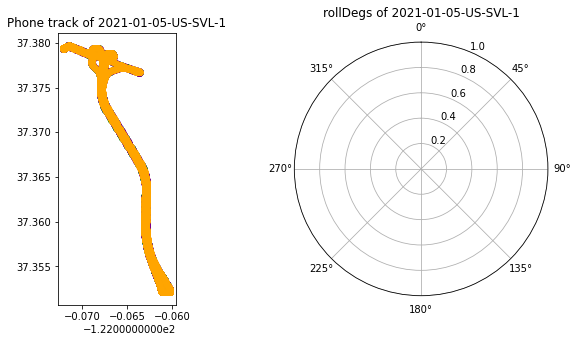

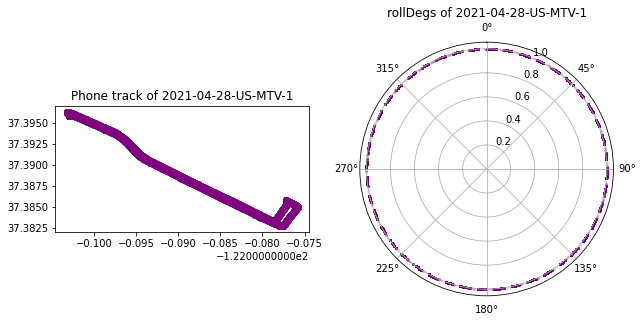

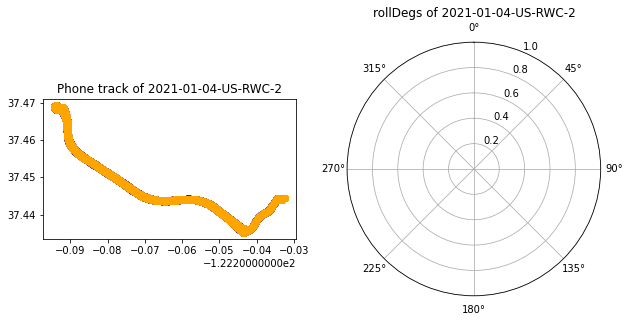

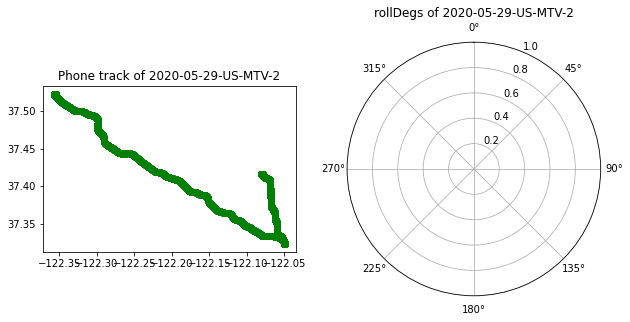

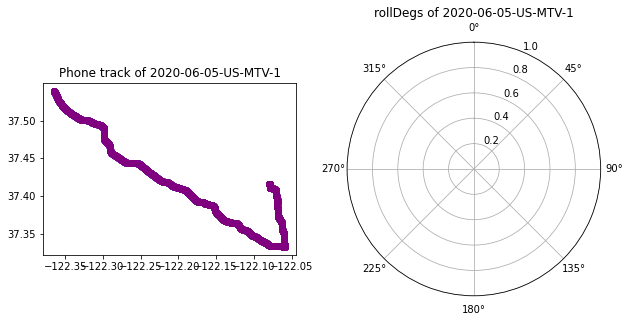

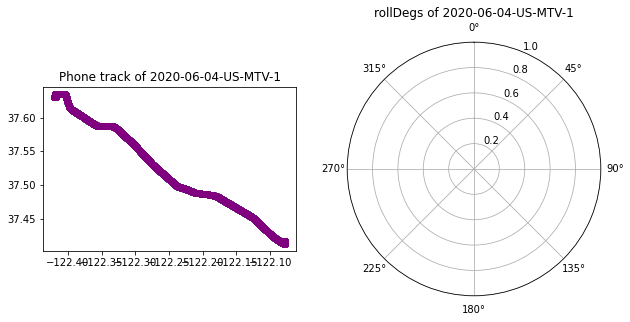

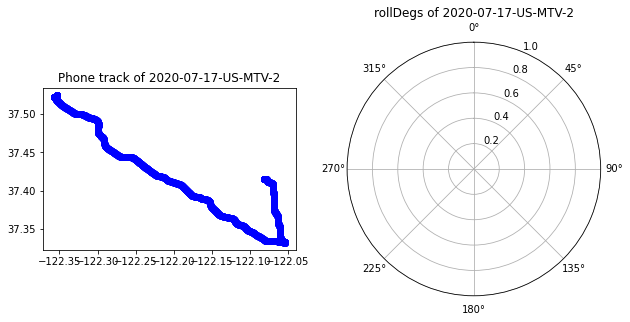

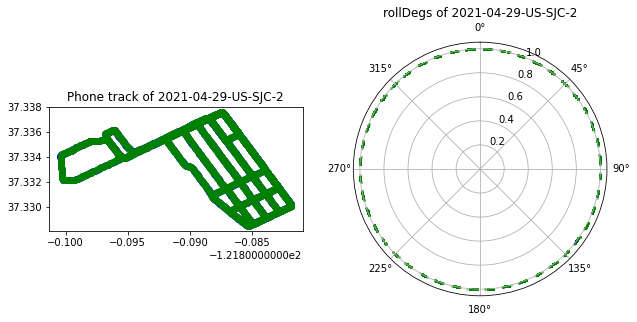

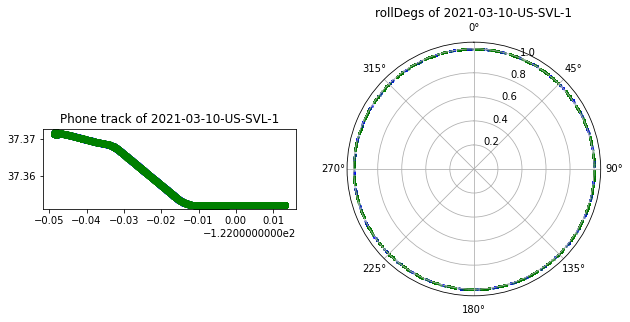

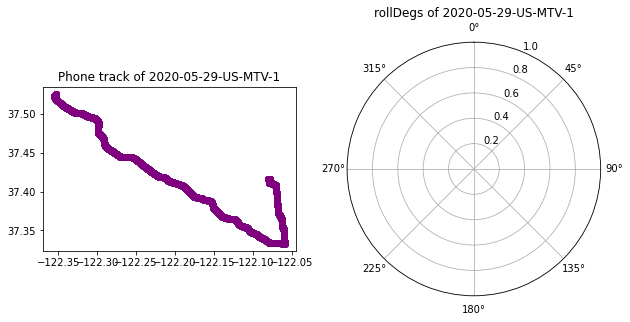

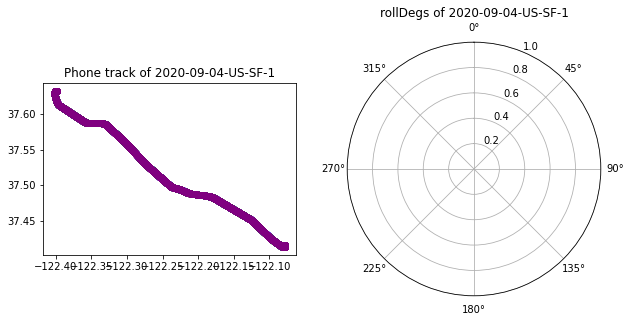

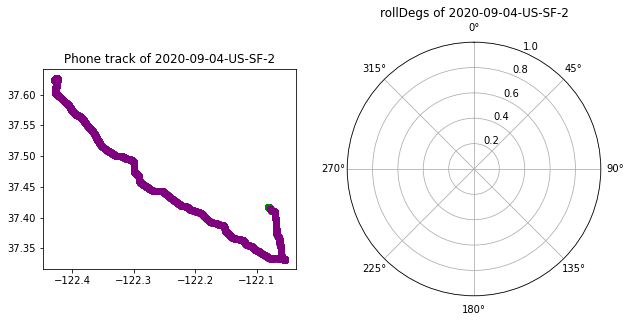

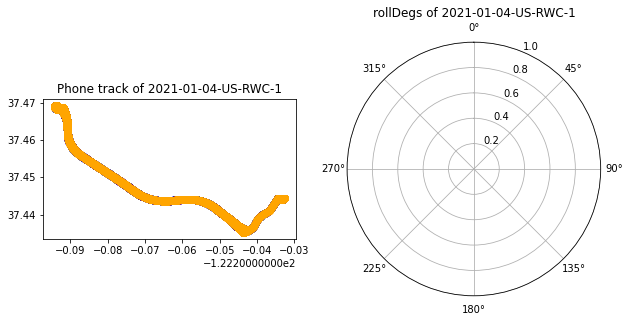

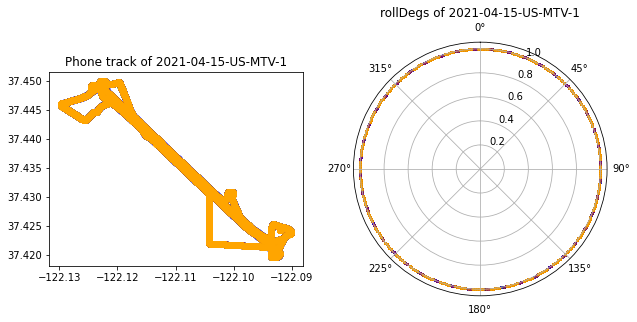

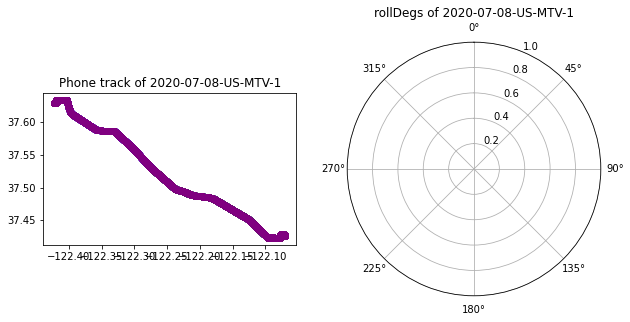

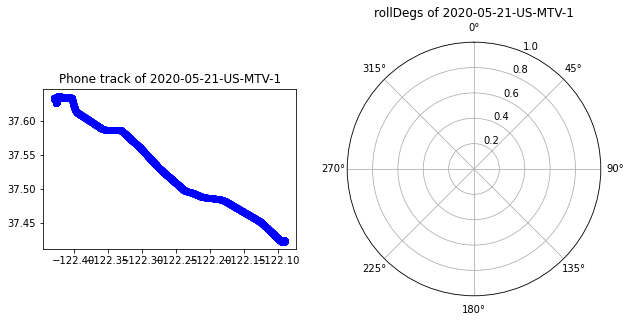

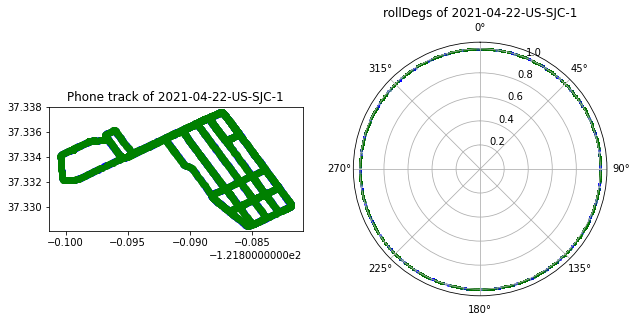

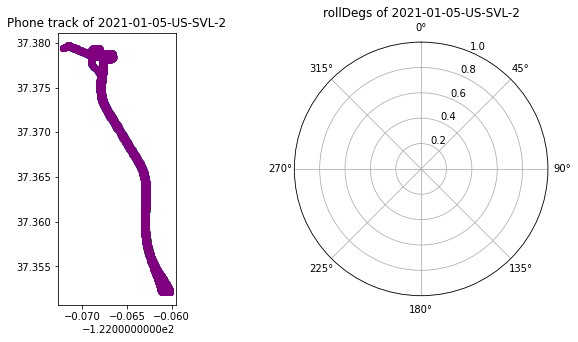

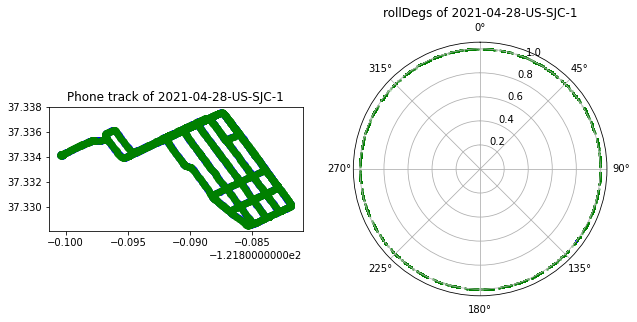

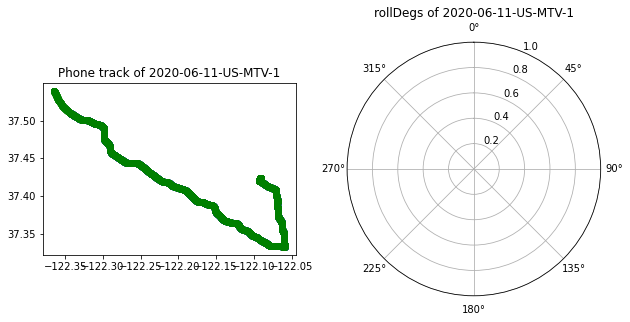

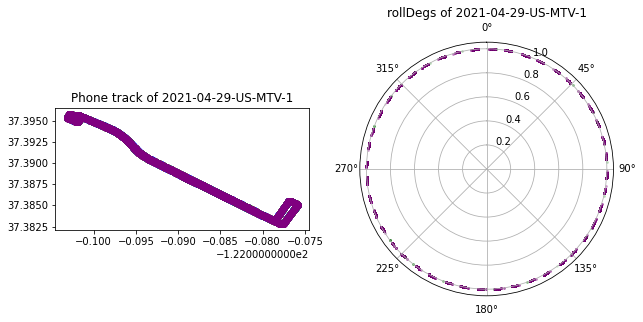

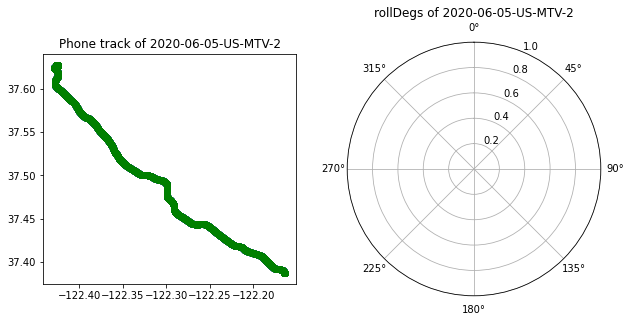

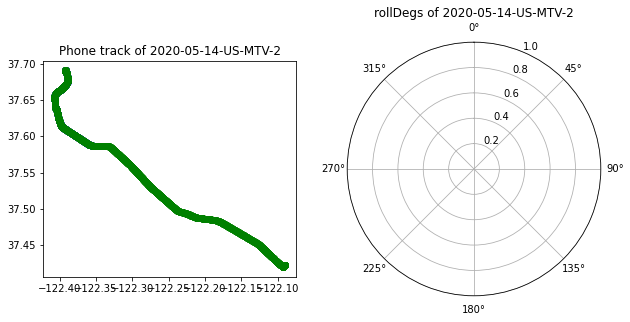

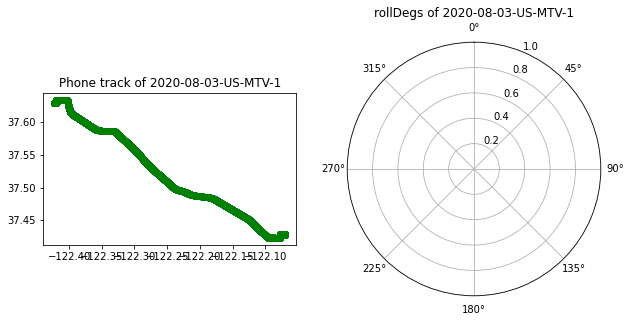

In [32]:
for i in range(len(collectionNames)):
    fig = plt.figure(figsize=(10, 5))
    axes0 = fig.add_subplot(121)
    axes1 = fig.add_subplot(122, projection='polar')
    axes1.set_theta_zero_location('N')
    axes1.set_theta_direction(-1)
    
    collectionName = collectionNames[i]
    gdfs_each_collectionName = gdfs[i]
    dfs_each_collectionName = dfs[i]
    
    for j in range(len(gdfs_each_collectionName)):
        g1 = gdfs_each_collectionName[j].plot(color=colors[j], ax=axes0)
        if "rollDeg" in dfs_each_collectionName[j].keys():
            axes1.scatter(dfs_each_collectionName[j]["rollDeg"],
                          [1 for i in range(len(dfs_each_collectionName[j]["rollDeg"]))],
                          alpha=0.1, s=3, color=colors[j])
    g1.set_title(f"Phone track of {collectionName}")
    axes1.set_title(f"rollDegs of {collectionName}")

<a id="3-2"></a>
## Which collection contains which phone 

I checked which phones were included in each collection. 

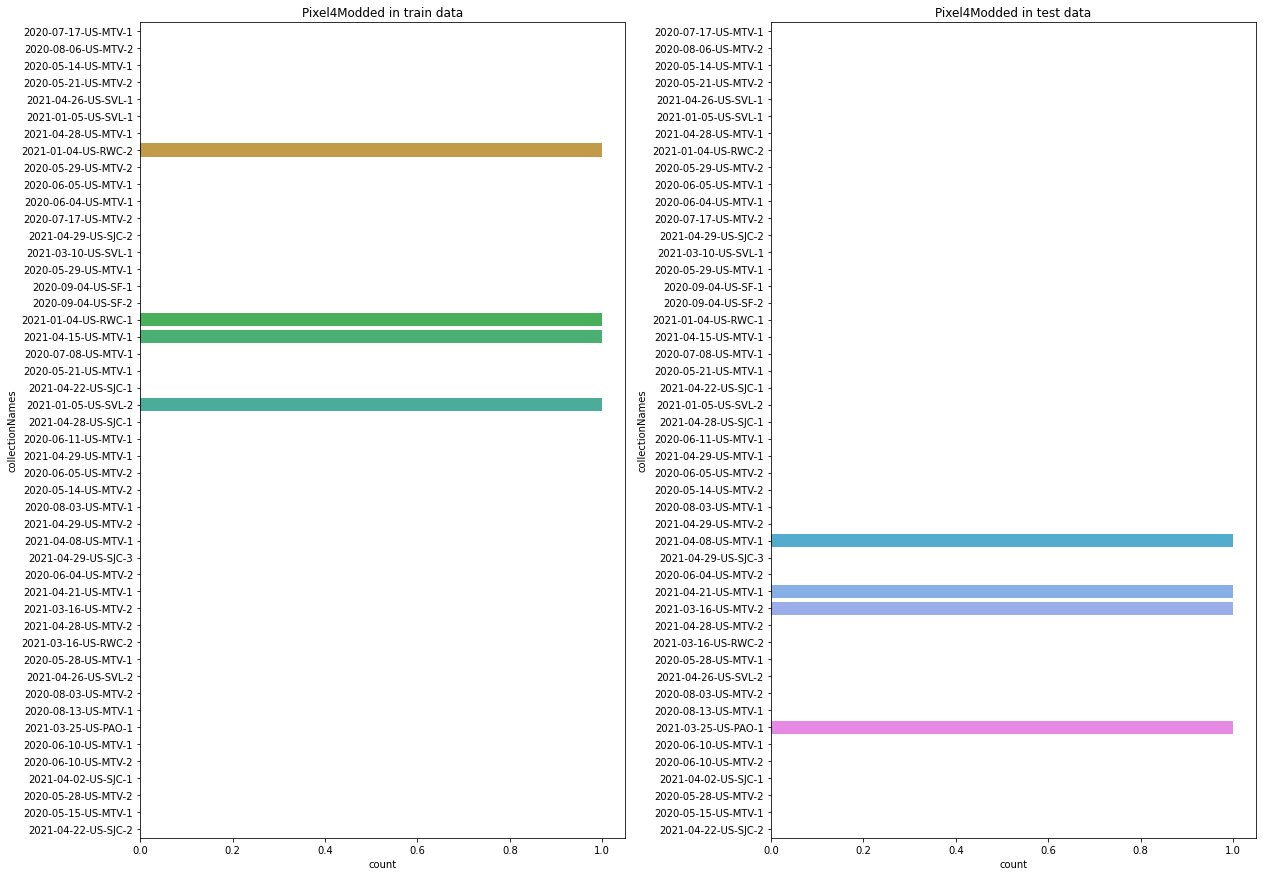

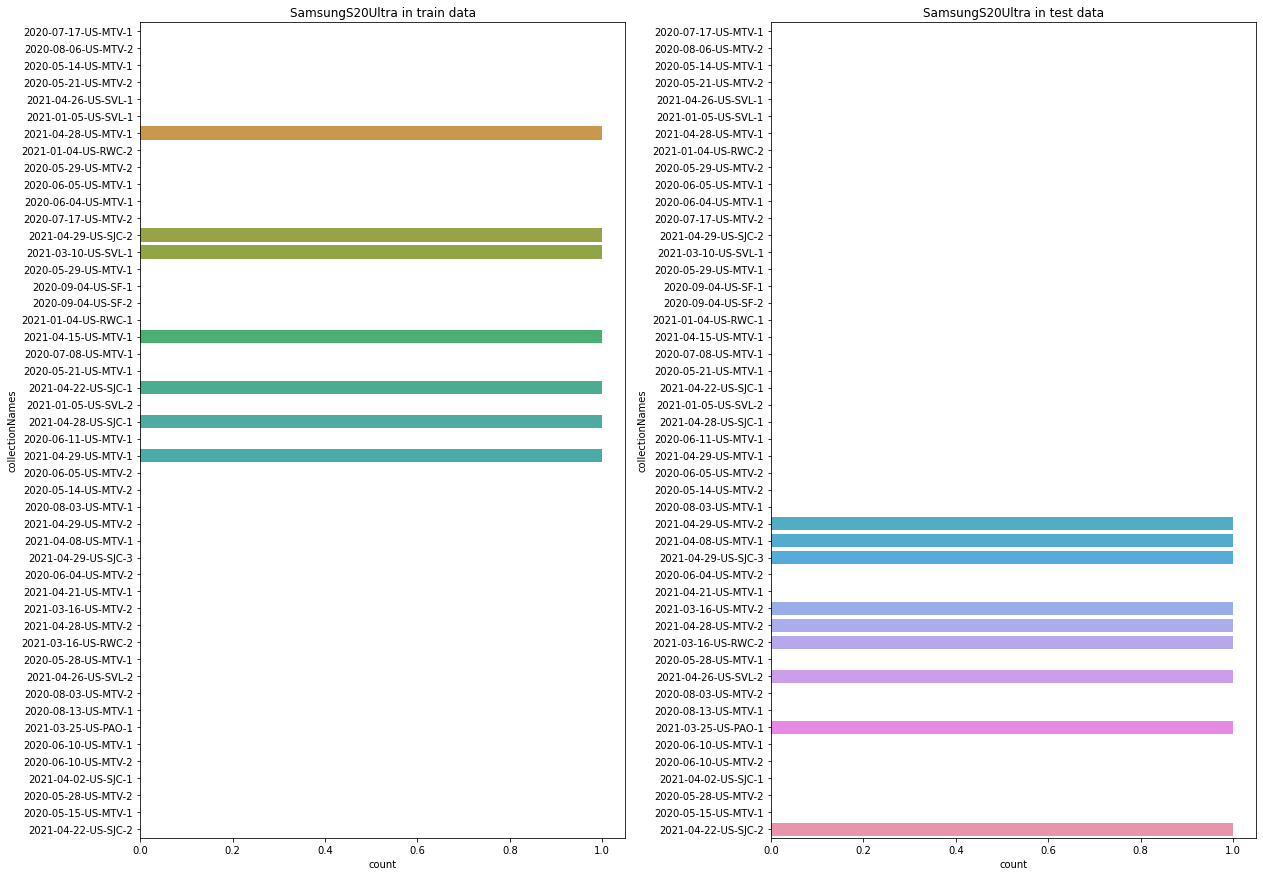

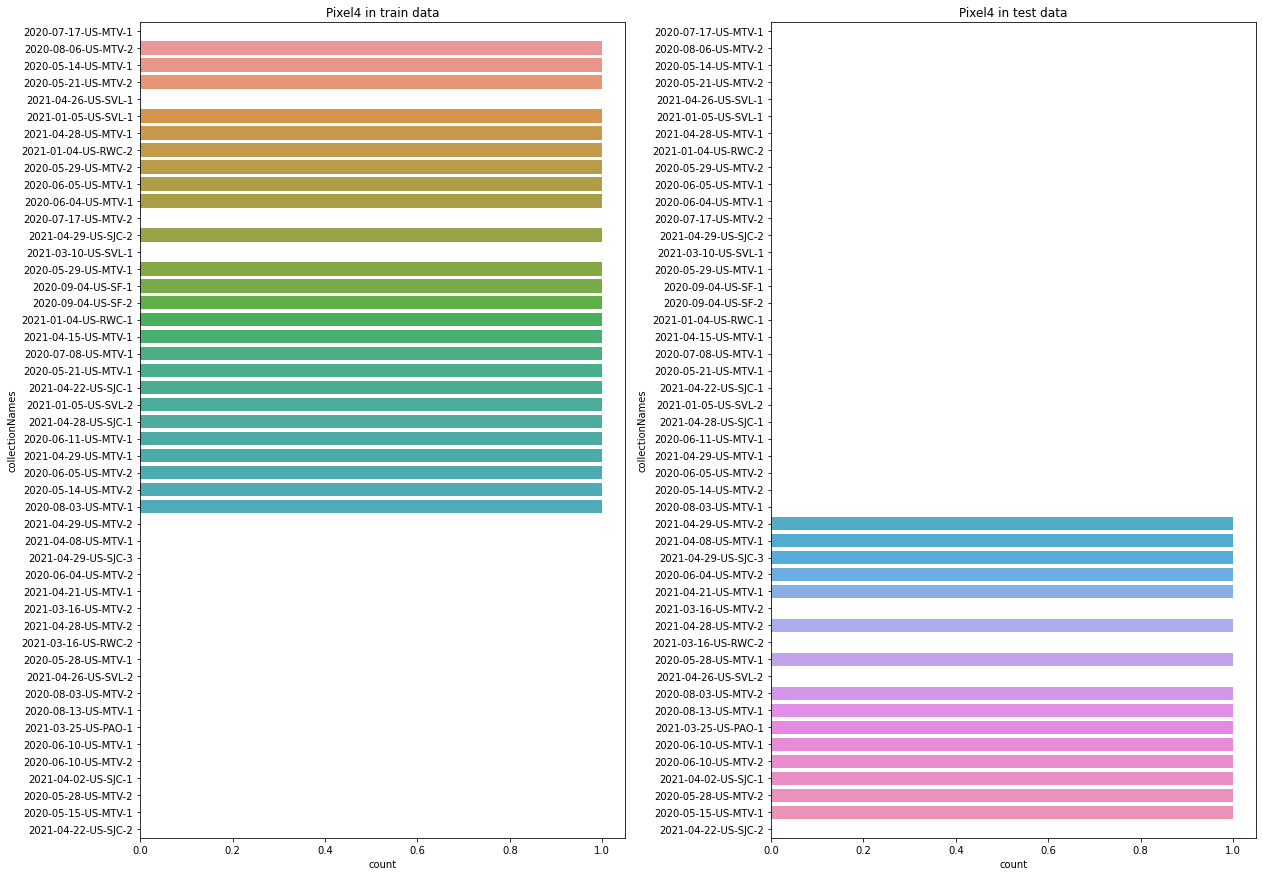

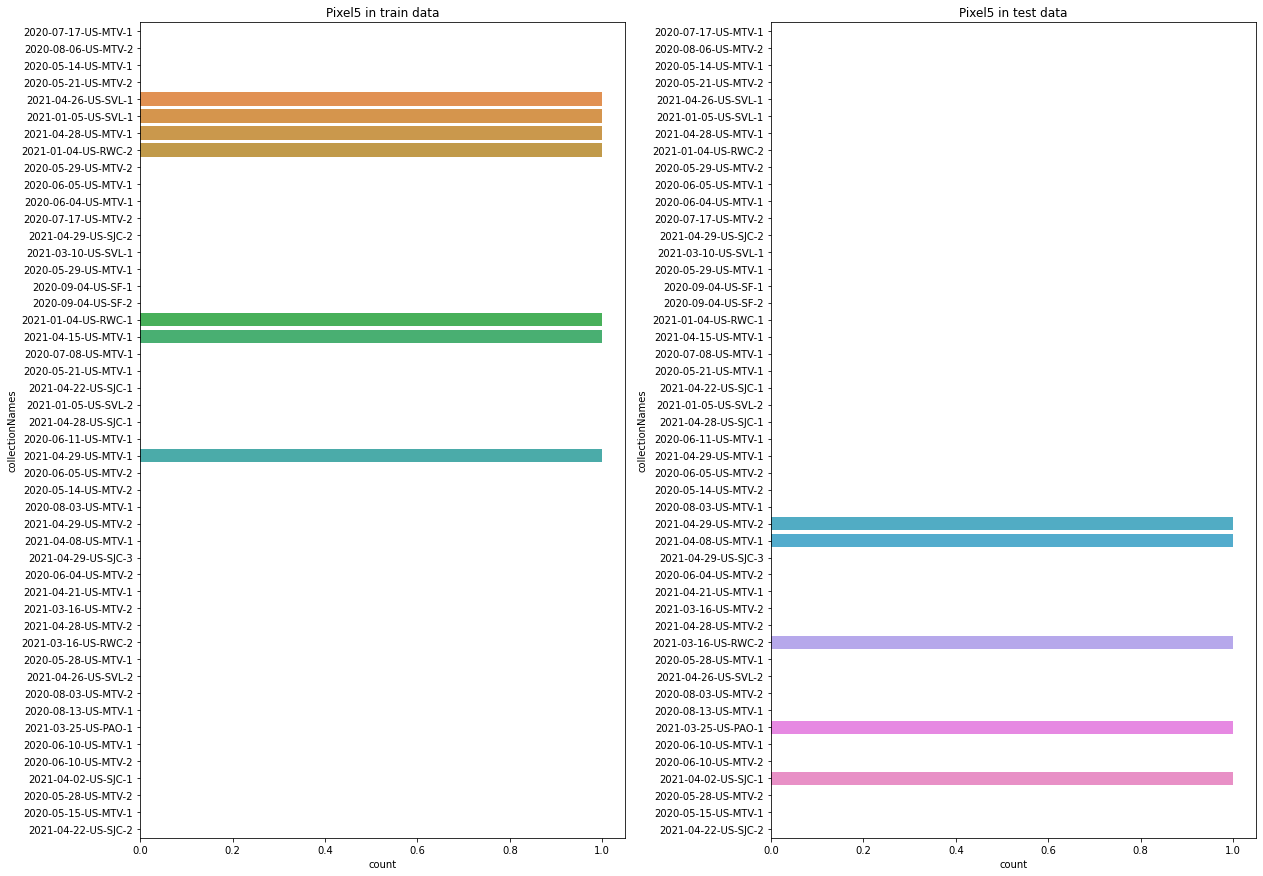

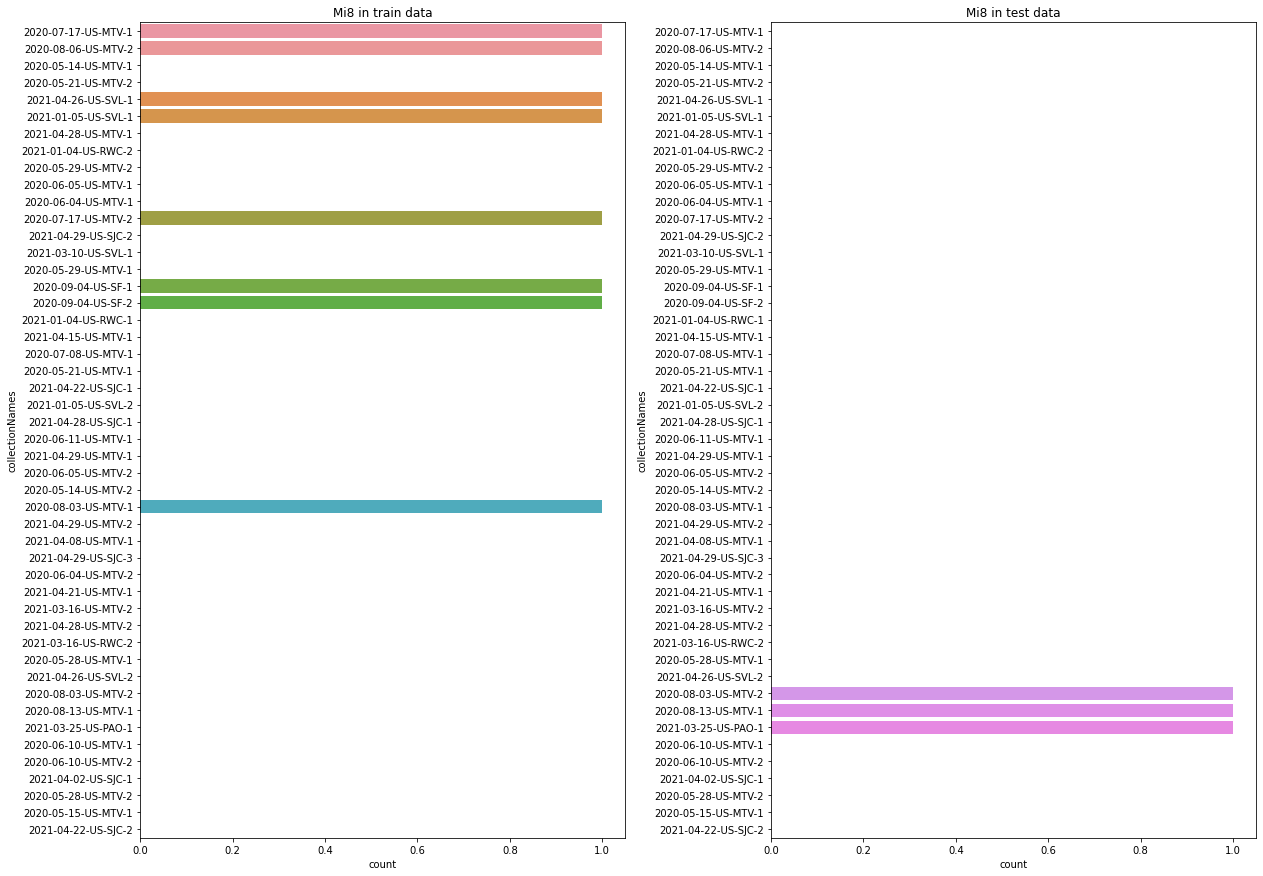

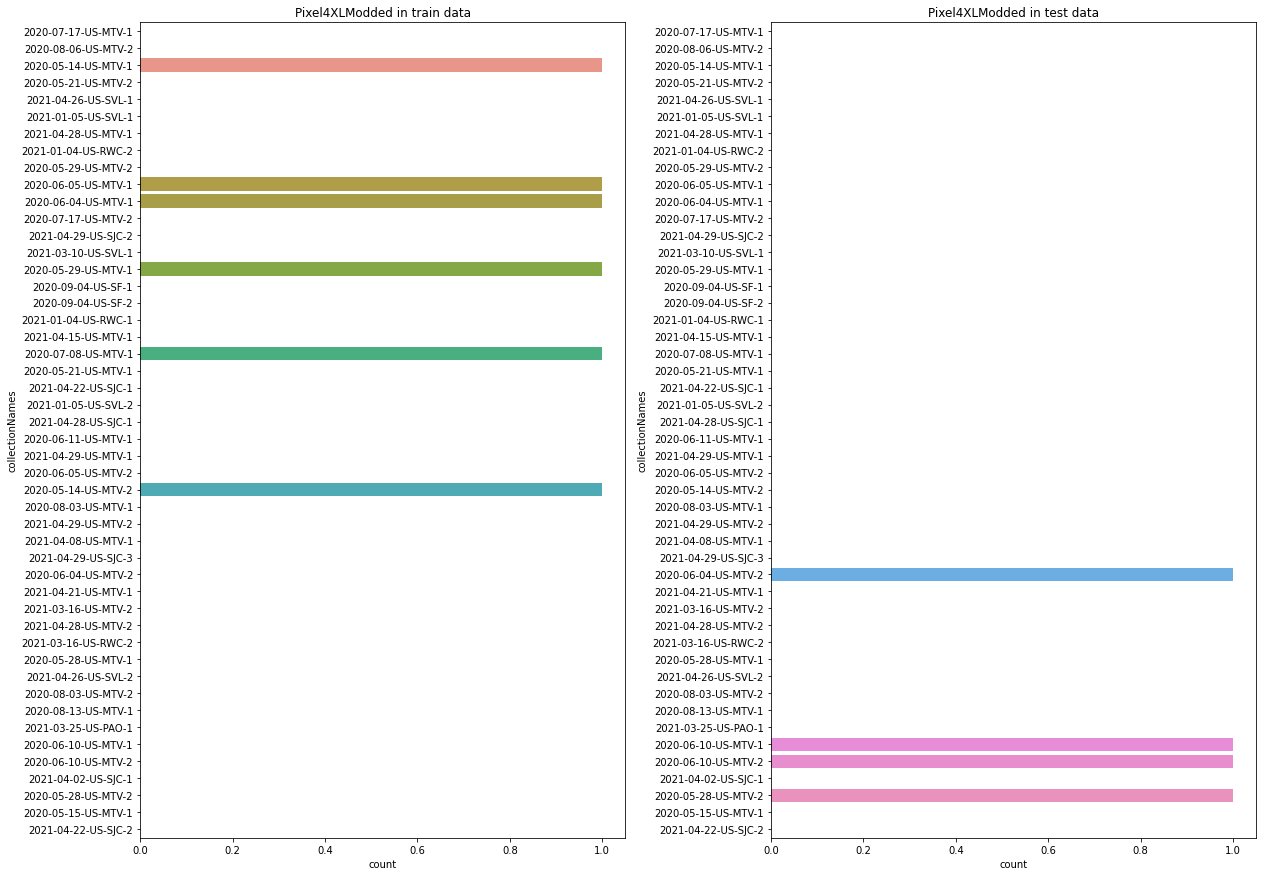

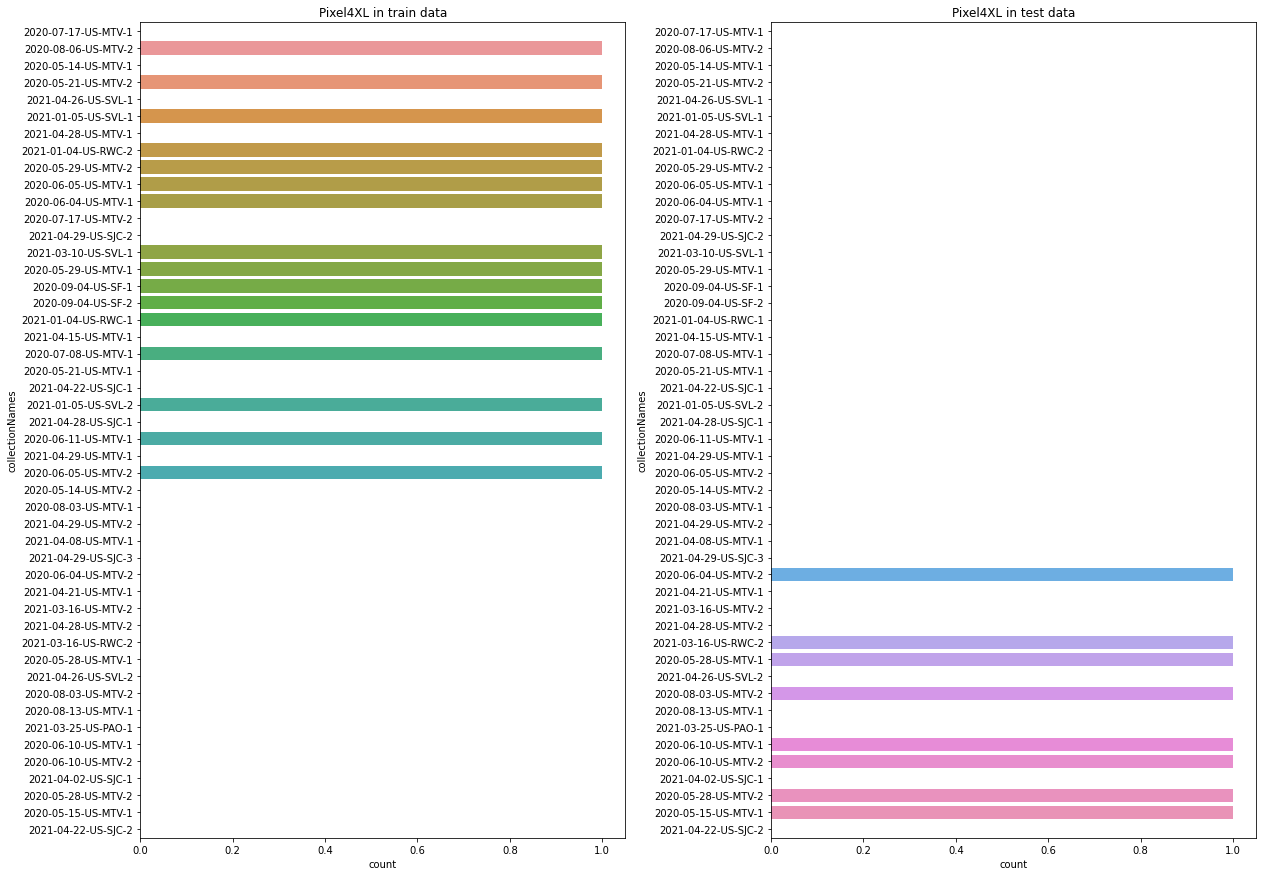

In [33]:
train_phones = glob.glob("../input/google-smartphone-decimeter-challenge/train/*/*")
test_phones = glob.glob("../input/google-smartphone-decimeter-challenge/test/*/*")

train_data = [item.split("/")[-2:] for item in train_phones]
test_data = [item.split("/")[-2:] for item in test_phones]

phoneNames = [item.split("/")[-1:] for item in train_phones] + [item.split("/")[-1:] for item in test_phones]
phoneNames = set(list(itertools.chain.from_iterable(phoneNames)))
collectionNames = [item.split("/")[-2] for item in train_phones] + [item.split("/")[-2] for item in test_phones]

def add_lack_data(data, phoneNames, collectionNames):
    result = []
    for collectionName in collectionNames:
        for phoneName in phoneNames:
            if [collectionName, phoneName] in data:
                result.append([collectionName, phoneName, 1])
            else:
                result.append([collectionName, phoneName, 0])
    return result

train_data = add_lack_data(train_data, phoneNames, collectionNames)
test_data = add_lack_data(test_data, phoneNames, collectionNames)

train_data = pd.DataFrame(train_data, columns=["collectionNames", "phoneNames", "count"])
test_data = pd.DataFrame(test_data, columns=["collectionNames", "phoneNames", "count"])

for phoneName in phoneNames:
    fig, axes = plt.subplots(1, 2, figsize=(20,15))
    plt.subplots_adjust(wspace=0.3, hspace=0.6)
    g1 = seaborn.barplot(data=train_data[train_data["phoneNames"] == phoneName],
                         x="count", y="collectionNames", ax=axes[0])
    g1.set_title(f"{phoneName} in train data")
    g2 = seaborn.barplot(data=test_data[test_data["phoneNames"] == phoneName],
                         x="count", y="collectionNames", ax=axes[1])
    g2.set_title(f"{phoneName} in test data")